## Feature Selection
```In this exercise you will experience a very under rated aspect of the data scientist job: feature selection.
We will look at the most common algorithms, examine them and will develop new feature selection algorithms.
The data you will be working on is pretty hard: you will soon find out why :)```

```Note: When questions are asked (you can identify a question by '?'), answer it in another cell and be prepared to talk about it with your tutor.```

```~Ittai Haran```

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

```Load data.csv. The data is made up from some measurements of soil in Africa, and was derived from Kaggle. SOC is the target.
```

In [6]:
df = pd.read_csv('resources/data.csv', index_col=0)

```Train a simple Random Forest model on the data. Use your knowledge to make it as good a model as you can. Don't forget to split the data to train and test segments.```

In [22]:
train_test_split([df.drop('SOC', axis=1), df['SOC']], train_size=0.7)[0]

C:\Users\MMM\AppData\Local\conda\conda\envs\python3_ittai\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


[      m7497.96  m7496.04  m7494.11  m7492.18  m7490.25  m7488.32  m7486.39  \
 0     0.302553  0.301137  0.299748  0.300354  0.302679  0.303799  0.301702   
 1     0.270192  0.268555  0.266964  0.267938  0.271013  0.272346  0.269870   
 2     0.317433  0.316265  0.314948  0.315224  0.316942  0.317764  0.316067   
 3     0.261116  0.259767  0.258384  0.259001  0.261310  0.262417  0.260534   
 4     0.260038  0.258425  0.256544  0.257030  0.259602  0.260786  0.258717   
 5     0.172350  0.170766  0.169383  0.170148  0.172570  0.173675  0.171809   
 6     0.354537  0.352801  0.351282  0.352225  0.355192  0.356416  0.354078   
 7     0.312328  0.310354  0.308660  0.309540  0.312404  0.313769  0.311575   
 8     0.351604  0.349781  0.348140  0.349015  0.351900  0.353247  0.351208   
 9     0.321137  0.319281  0.317571  0.318293  0.321233  0.322900  0.320903   
 10    0.318528  0.316745  0.315244  0.316218  0.319089  0.320168  0.317681   
 11    0.271869  0.270120  0.268421  0.269073  0.271

C:\Users\MMM\AppData\Local\conda\conda\envs\python3_ittai\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


2
3
4
5
6
7
8
9
10
11


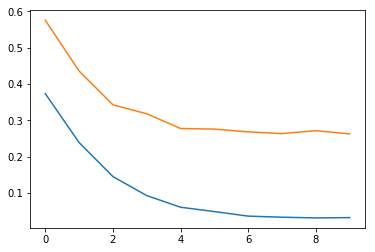

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df_train, df_test, target_train, target_test = train_test_split(df.drop('SOC', axis=1), df['SOC'], train_size=0.7)
error_train = []
error_test = []
for depth in range(2,12):
    clf = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=depth)
    clf.fit(df_train, target_train)
    
    error_train.append(mean_squared_error(clf.predict(df_train), target_train))
    error_test.append(mean_squared_error(clf.predict(df_test), target_test))
    
    print(depth)
    
plt.plot(error_train)
plt.plot(error_test)
plt.show()

In [32]:
clf = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=7)
clf.fit(df_train, target_train)
print(mean_squared_error(clf.predict(df_train), target_train))
print(mean_squared_error(clf.predict(df_test), target_test))

0.04823649883608305
0.27609763746808547


```Use model.feature_importances_ to select the 100 most important features. Use these features to train your model. Did you get better results on the train segment? what are results on the test segment?
How does model.feature_importances_ work? Some features have 0 importance. Why?```

In [35]:
features = [x[0] for x in sorted(zip(df.columns, clf.feature_importances_), key = lambda x: -x[1])][:100]
clf_selected = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=7)
clf_selected.fit(df_train[features], target_train)
print(mean_squared_error(clf_selected.predict(df_train[features]), target_train))
print(mean_squared_error(clf_selected.predict(df_test[features]), target_test))

0.04902182738595473
0.2620029368672982


```Well, that didn't work quite so good. Let's try a different approach. Now select the 100 features that are most correlated to the data. What results did you get now? You got so far two groups of feature selected. Are they similar to one another? Why or why not?```

In [37]:
corrs = np.corrcoef(df_train.transpose(), target_train)
corr_features = sorted(list(zip(list(df.columns)+['SOC'], corrs[-1])), key = lambda x: -x[1])[1:]
corr_features = [x[0] for x in corr_features[:100]]

In [38]:
clf_selected = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=7)
clf_selected.fit(df_train[corr_features], target_train)
print(mean_squared_error(clf_selected.predict(df_train[corr_features]), target_train))
print(mean_squared_error(clf_selected.predict(df_test[corr_features]), target_test))

0.17848483823383735
0.6757140666780279


```Now cluster the features by their correlation to one another. Make sure you have at least ~30 clusters. Pick from each cluster the feature most correlated to the target. What are your results now? What clustering algorithm did you use?```

In [39]:
from sklearn.cluster import DBSCAN
clusters = DBSCAN(eps = 0.001, metric="precomputed").fit_predict(1-abs(corrs))

In [41]:
def choose(x):
    return max(x, key = lambda x: -x[0])[1]

choose_features = pd.DataFrame(list(zip(clusters, zip(corrs[-1], list(df.columns)+['SOC'])))).iloc[:-1]
features_selected_corr = choose_features.groupby(0).agg(choose)[1]

In [43]:
clf_selected = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=7)
clf_selected.fit(df_train[features_selected_corr], target_train)
print(mean_squared_error(clf_selected.predict(df_train[features_selected_corr]), target_train))
print(mean_squared_error(clf_selected.predict(df_test[features_selected_corr]), target_test))

0.058263596784614964
0.2595219874849178


```Before we continue, read the documentation of sklearn.feature_selection. What other feature selection algorithms did you find there? try one of them on your data.```

```You are about to be very surprised. select 100 features randomly and evaluate the model trained with them. Repeat it 100 times. What is the best set of feature you got? How is it compared to the other subsets you got so far? Can you explain it?```

In [46]:
features_list = []
for i in range(100):
    features_random = list(set(np.random.choice(df_train.columns, size = 30)))
    clf_selected = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=7)
    clf_selected.fit(df_train[features_random], target_train)
    print(mean_squared_error(clf_selected.predict(df_train[features_random]), target_train))
    print(mean_squared_error(clf_selected.predict(df_test[features_random]), target_test))
    print('-----------------------------------')
    features_list.append((features_random,
                        mean_squared_error(clf_selected.predict(df_train[features_random]), target_train),
                        mean_squared_error(clf_selected.predict(df_test[features_random]), target_test)))

0.05651201537665083
0.2698342353126435
-----------------------------------
0.06652265540084935
0.2666013022298534
-----------------------------------
0.10332783741087836
0.47793577733448994
-----------------------------------
0.11216290703690901
0.5686818617113927
-----------------------------------
0.09932412562193454
0.49135344273392534
-----------------------------------
0.08133461822503883
0.3487035946388528
-----------------------------------
0.0723437052826911
0.29926554381640874
-----------------------------------
0.10946440971540161
0.4258561770824264
-----------------------------------
0.10787523452059077
0.42030279794374464
-----------------------------------
0.05375622421113419
0.2319850945474299
-----------------------------------
0.08447351736095826
0.3557712773508264
-----------------------------------
0.1252398108785685
0.5470485854819532
-----------------------------------
0.0635738885662912
0.2451021495574238
-----------------------------------
0.08012142393384909
0.31

In [48]:
features_rand_selected = min(features_list, key = lambda x: x[2])[0]
clf_selected = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=7)
clf_selected.fit(df_train[features_rand_selected], target_train)
print(mean_squared_error(clf_selected.predict(df_train[features_rand_selected]), target_train))
print(mean_squared_error(clf_selected.predict(df_test[features_rand_selected]), target_test))

0.05723467980698782
0.22831512116944946


```Now it's your time to enter the office's competition for feature selection. Invent your own feature selection algorithm. Make it a good one (because if it isn't, your tutor might ask you to implement one of the other algorithms proposed by the office's members, and that might be awful ;) ) Before you act, talk about your idea with your tutor.```